# TASK 1: REGRESSION

## Define:
1. Objectives: Build a regression model to predict "median_house_value".
2. Data sources: https://www.kaggle.com/datasets/camnugent/california-housing-prices
3. Strategy: Conclude on one optimal model by trying out the different algorithms used in class.

In [1]:
# Import key libraries
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as profiling
import sqlite3
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector

## Get data from database

In [4]:
# Establish connection with project.db
sqlite_db = r"D:\git_repo_IO_mini_project2\IOD_mini_project2\Database\project.db" # rename root directory to your own directory
conn = sqlite3.connect(sqlite_db)

In [5]:
df_housing = pd.read_sql_query("SELECT * FROM housing_raw",con=conn)
df_housing.drop(columns=["index"],inplace=True)
df_housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

## Exploratory Data Analysis (EDA)

In [9]:
prof = profiling.ProfileReport(df_housing)
prof.to_file("housing_profiling.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 73.36it/s]


In [6]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [58]:
df_housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

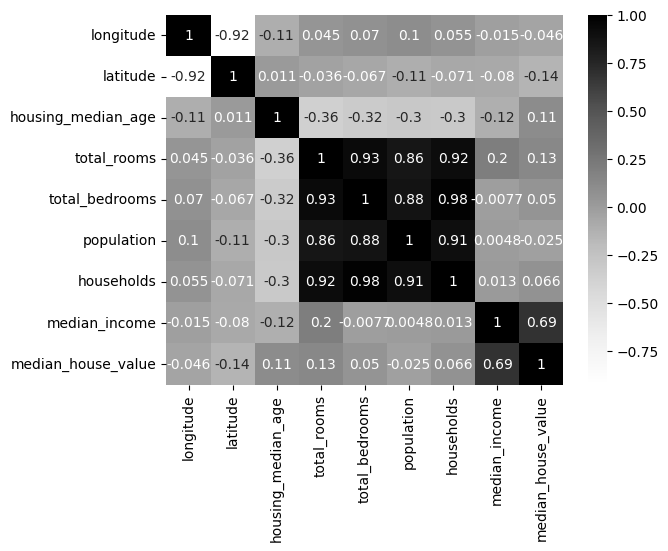

In [59]:
sns.heatmap(df_housing.corr(numeric_only=True),annot=True,cmap="Greys")
plt.show()

C:\Users\Admin\anaconda3\envs\IOD_mini_project2\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


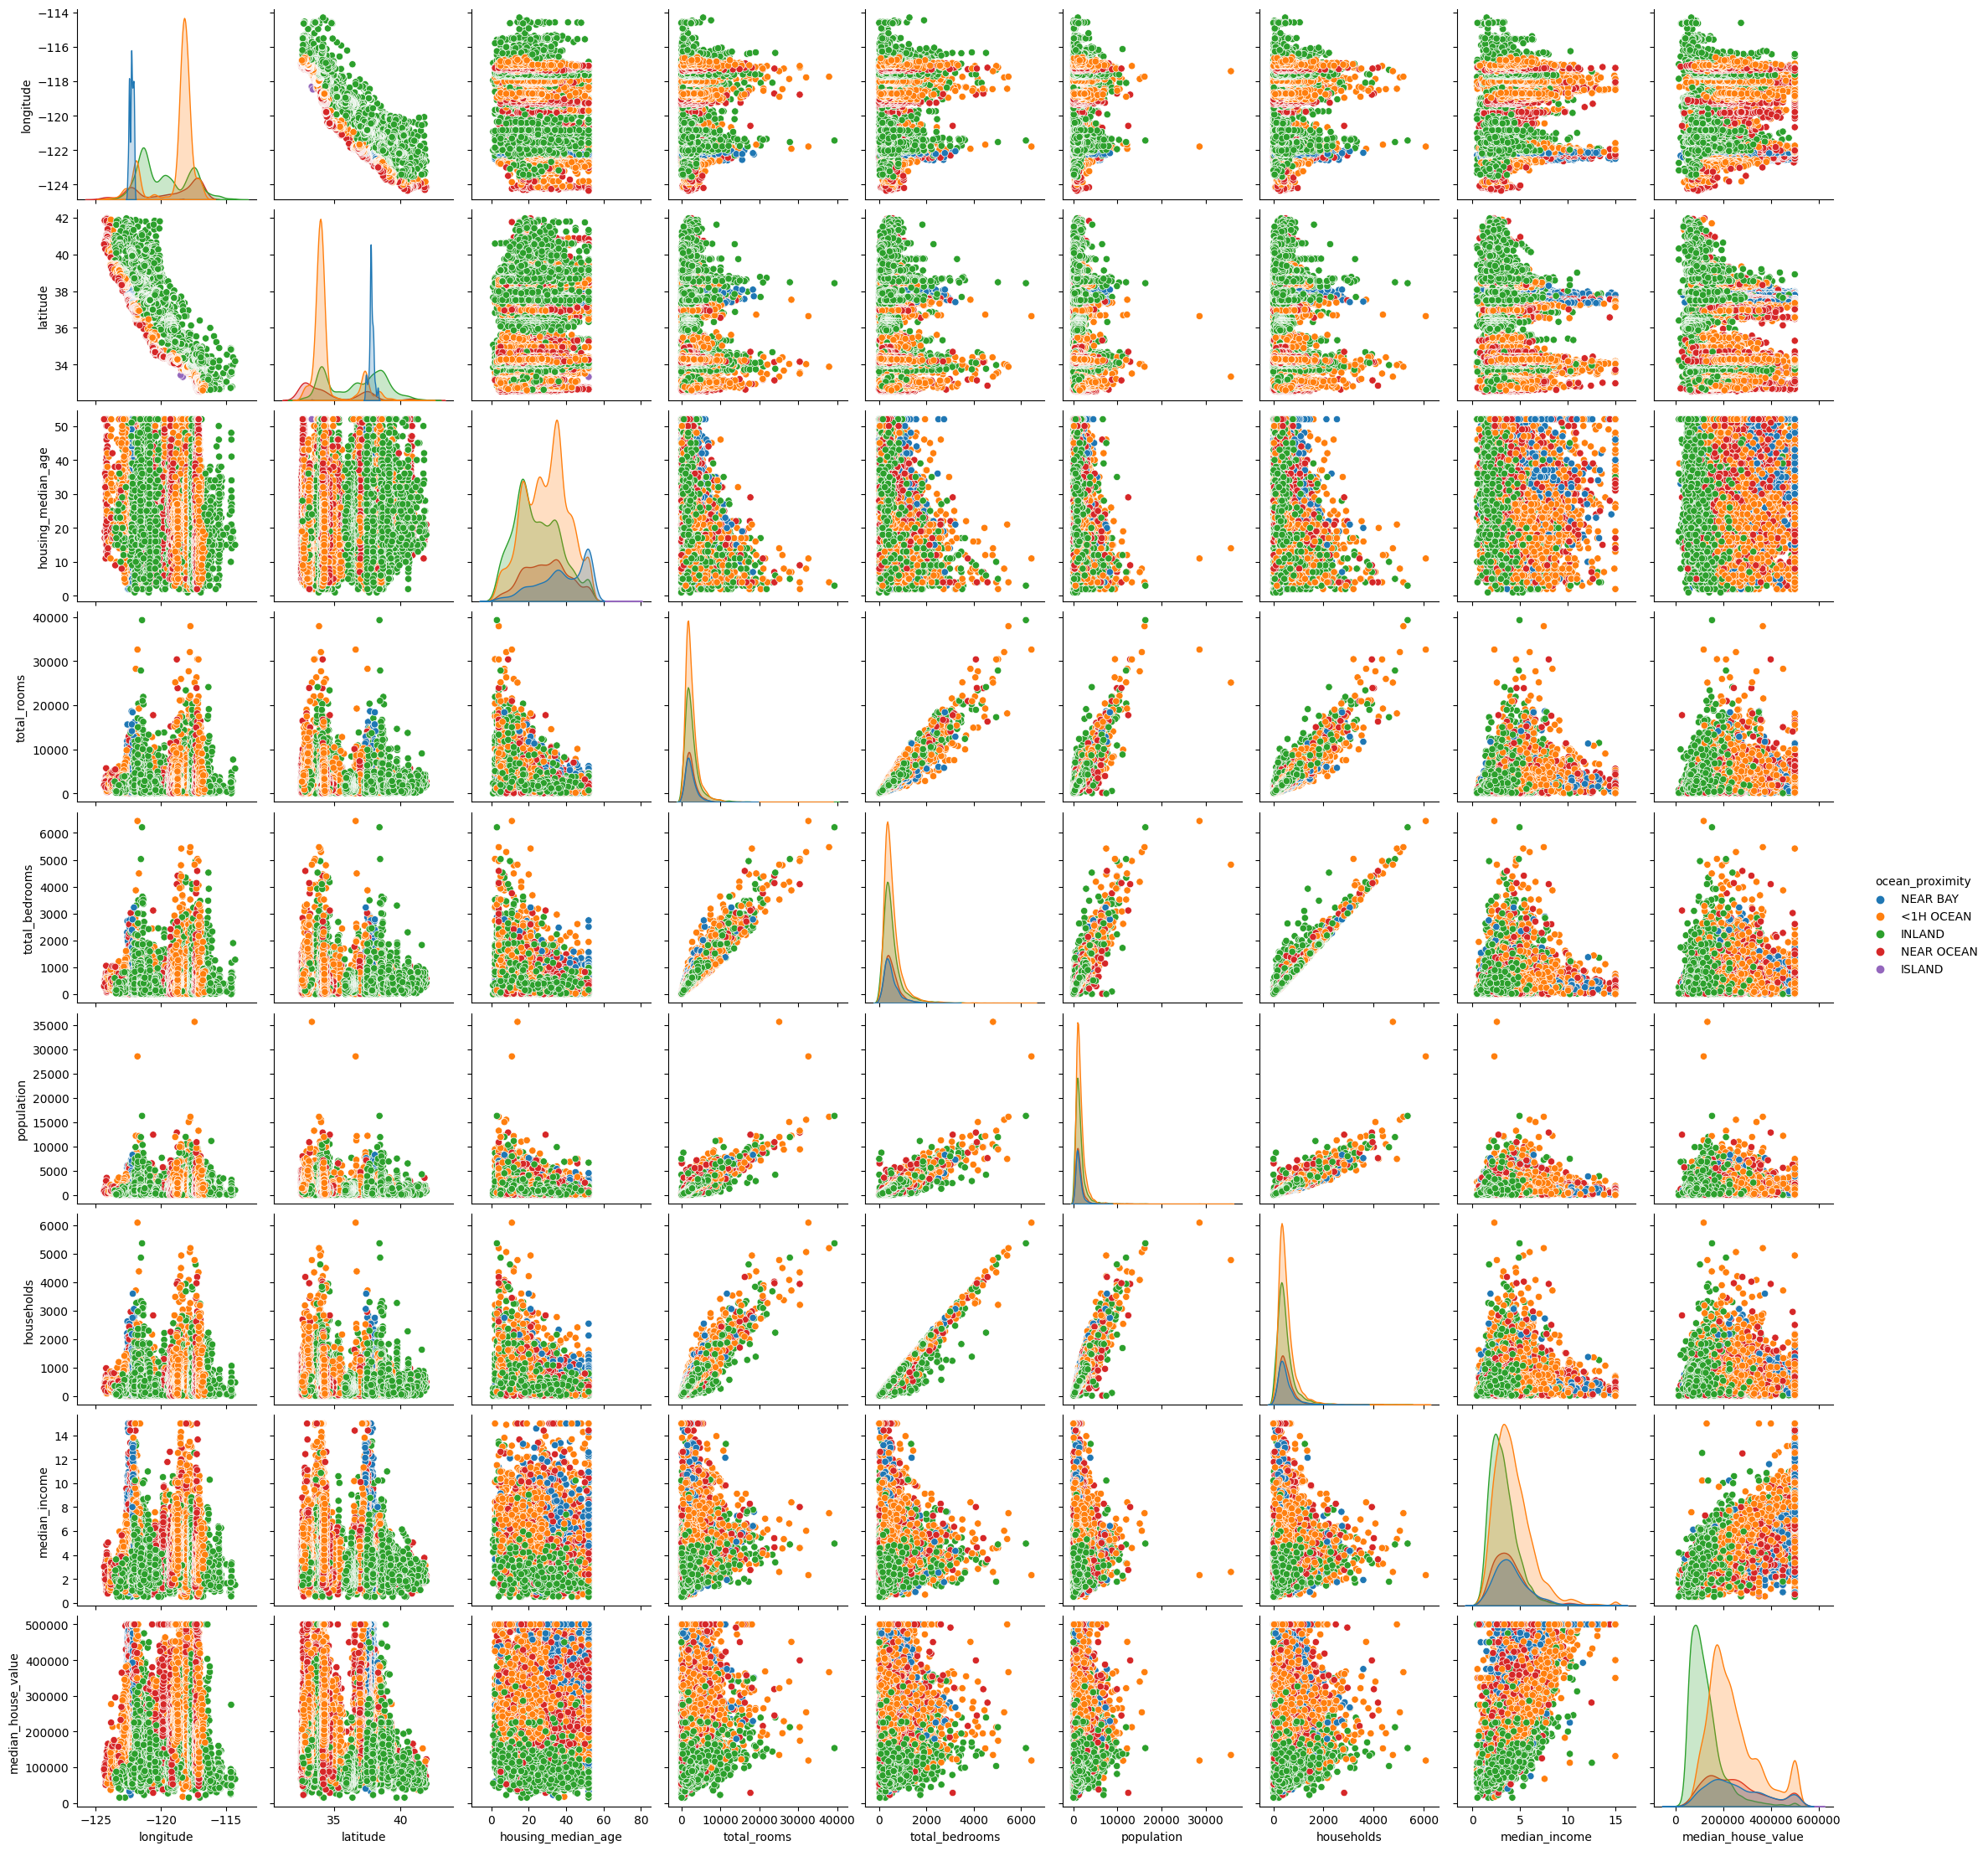

In [30]:
sns.pairplot(data=df_housing,hue="ocean_proximity",dropna=True)
plt.show()

## Preprocessing

In [4]:
# Get sum of null values for each feature
df_housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# Get df with no null values
df_housing_dropNA = df_housing.dropna()
df_housing_dropNA.reset_index(drop=True,inplace=True)
df_housing_dropNA.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

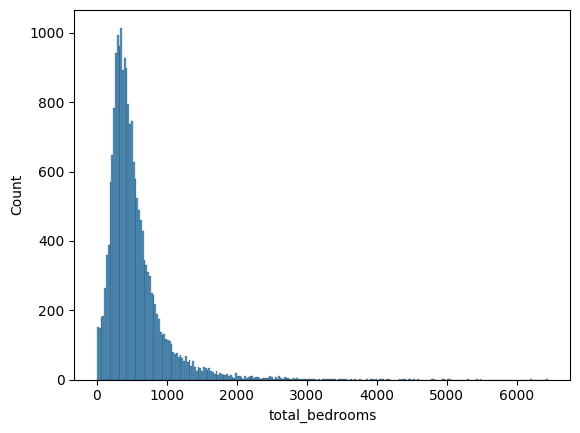

In [11]:
# Get histplot of total_bedrooms
sns.histplot(df_housing["total_bedrooms"])
plt.show()

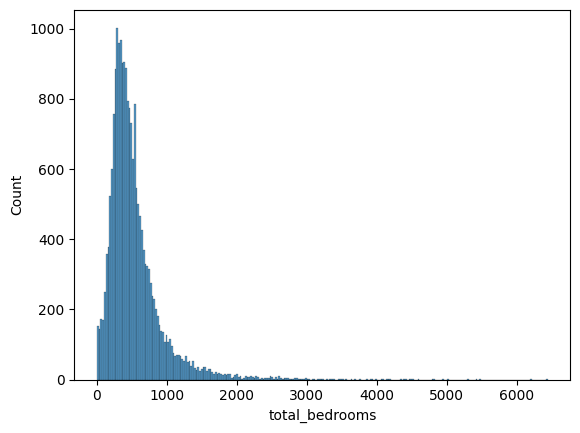

In [12]:
# Replace nan values with mean
df_housing["total_bedrooms"] = df_housing["total_bedrooms"].replace(np.nan,df_housing["total_bedrooms"].mean())
# Histplot does not differ much as missing values are ~10% of data
sns.histplot(df_housing["total_bedrooms"])
plt.show()

In [13]:
# One hot encoding for column: ocean_proximity
df_housing_dummies = pd.get_dummies(df_housing,prefix="OP",drop_first=True,dtype=int)
df_housing_dummies.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  OP_INLAND  \
0       322.0       126.0         8.3252            452600.0          0   
1      2401.0      1138.0         8.3014            358500.0          0   
2       496.0       177.0         7.2574            352100.0          0   
3       558.0       219.0         5.6431            341300.0          0   
4       565.0       259.0         3.8462            342200.0          0   

   OP_ISLAND  OP_NEAR BAY  OP_NEAR OCEAN  
0          0            1              0  
1          0            1              0  
2          0            1              0  
3          0            1              0  
4          0            1              0

## Modelling

In [185]:
model_results = {"Model":[],"Score":[],"MSE":[]}

### Base model

#### LinearRegression: df_housing_dropNA

In [186]:
# Define predictor and target variables
list_pred_col = df_housing_dropNA.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("ocean_proximity") # excluding categorical variable
# list_pred_col.remove("longitude")
# list_pred_col.remove("latitude")
X = df_housing_dropNA[list_pred_col]
y = df_housing_dropNA["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
reg = LinearRegression()

# Fit model and predict y_pred
reg.fit(X_train,y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Print scores and MSE
print("Linear regression score (train):",reg.score(X_train,y_train))
print("Linear regression score (test):",reg.score(X_test,y_test))
print("Linear regression MSE (train):",mean_squared_error(y_true=y_train,y_pred=y_pred_train))
print("Linear regression MSE (test):",mean_squared_error(y_true=y_test,y_pred=y_pred_test))

Linear regression score (train): 0.6308141791687536
Linear regression score (test): 0.6484161402008852
Linear regression MSE (train): 4860953673.584888
Linear regression MSE (test): 4794696331.859299


In [126]:
# Set up 5-fold cross validation  
k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    reg = LinearRegression().fit(X_train,y_train)
    # Make predictions with training and test set
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(reg.score(X_train,y_train))
    train_rmse.append(mean_squared_error(y_true=y_train,y_pred=pred_train))
    test_scores.append(reg.score(X_test,y_test))
    test_rmse.append(mean_squared_error(y_true=y_test,y_pred=pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_rmse':train_rmse,'test_scores':test_scores,'test_rmse':test_rmse}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

train_scores    train_rmse  test_scores     test_rmse
0      0.638877  4.796841e+09     0.629103  5.003479e+09
1      0.635750  4.824633e+09     0.641161  4.895315e+09
2      0.637123  4.826040e+09     0.635952  4.887729e+09
3      0.640431  4.817278e+09     0.621471  4.933762e+09
4      0.632732  4.920796e+09     0.653656  4.512905e+09

#### LinearRegression: df_housing

In [148]:
# Define predictor and target variables
list_pred_col = df_housing.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("ocean_proximity") # excluding categorical variable
# list_pred_col.remove("longitude")
# list_pred_col.remove("latitude")
X = df_housing[list_pred_col]
y = df_housing["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
reg = LinearRegression()

# Fit model and predict y_pred
reg.fit(X_train,y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Print scores and MSE
print("Linear regression score (train):",reg.score(X_train,y_train))
print("Linear regression score (test):",reg.score(X_test,y_test))
print("Linear regression MSE (train):",mean_squared_error(y_true=y_train,y_pred=y_pred_train))
print("Linear regression MSE (test):",mean_squared_error(y_true=y_test,y_pred=y_pred_test))

Linear regression score (train): 0.6334551803587501
Linear regression score (test): 0.639691956221457
Linear regression MSE (train): 4862732453.52815
Linear regression MSE (test): 4833533594.890778


In [128]:
# Set up 5-fold cross validation  
k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    reg = LinearRegression().fit(X_train,y_train)
    # Make predictions with training and test set
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(reg.score(X_train,y_train))
    train_rmse.append(mean_squared_error(y_true=y_train,y_pred=pred_train))
    test_scores.append(reg.score(X_test,y_test))
    test_rmse.append(mean_squared_error(y_true=y_test,y_pred=pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_rmse':train_rmse,'test_scores':test_scores,'test_rmse':test_rmse}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

train_scores    train_rmse  test_scores     test_rmse
0      0.635070  4.849382e+09     0.637304  4.867533e+09
1      0.637362  4.865964e+09     0.628128  4.798778e+09
2      0.639142  4.798094e+09     0.618917  5.102554e+09
3      0.632136  4.870505e+09     0.648667  4.780134e+09
4      0.635206  4.864004e+09     0.637091  4.806050e+09

#### LinearRegression: df_housing_dummies

In [14]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude")
list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Define model
reg = LinearRegression()

# Fit model and predict y_pred
reg.fit(X_train,y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Print scores and MSE
print("Linear regression score (train):",reg.score(X_train,y_train))
print("Linear regression score (test):",reg.score(X_test,y_test))
print("Linear regression MSE (train):",mean_squared_error(y_true=y_train,y_pred=y_pred_train))
print("Linear regression MSE (test):",mean_squared_error(y_true=y_test,y_pred=y_pred_test))

# get the number of cases in the training data
n = X_train.shape[0]
# number of predictors in this model
k = len(X) + 1
# calculate the adjusted R^2
r2 = reg.score(X_test,y_test)
adjusted_r2 = 1-(((1-r2)*(n-1))/(n-k-1)) # calculate the Adjusted R^2
adjusted_r2

Linear regression score (train): 0.6317142411253328
Linear regression score (test): 0.6375890682042074
Linear regression MSE (train): 4885828460.500078
Linear regression MSE (test): 4861743844.573455


1.735405922210218

In [15]:
pickle.dump(reg, open('reg.pkl', 'wb'))

In [16]:
pickled_model = pickle.load(open('reg.pkl', 'rb'))
pickled_model.predict(X_test)

array([254077.8811394 , 311011.0364575 , 176885.84804406, ...,
        82160.29154612, 263458.50452826,  77366.51840967])

In [48]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(reg,
         k_features='best',
         forward=False,
         floating=False,
         scoring='r2',
         cv=30)

sfs = sfs.fit(X_train,y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T

feature_idx  \
10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
9      (0, 1, 2, 3, 4, 5, 6, 7, 9)   
8         (0, 1, 2, 3, 4, 5, 6, 9)   
7            (0, 2, 3, 4, 5, 6, 9)   
6               (0, 3, 4, 5, 6, 9)   
5                  (0, 3, 4, 5, 6)   
4                     (3, 4, 5, 6)   
3                        (4, 5, 6)   
2                           (5, 6)   
1                             (5,)   

                                            cv_scores avg_score  \
10  [0.6632142003682588, 0.614880850375126, 0.6309...  0.627571   
9   [0.6631442731639794, 0.6156957711031188, 0.631...  0.627556   
8   [0.6632173367136558, 0.6157159339180818, 0.631...  0.626918   
7   [0.6604096721275977, 0.6143244214980348, 0.630...  0.625785   
6   [0.6593698163555023, 0.6132018872427951, 0.631...  0.625168   
5   [0.6597716704378145, 0.6137782777470502, 0.628...  0.623826   
4   [0.6460879571691538, 0.5973207120644544, 0.609...  0.610578   
3   [0.6137425088010849, 0.556605442932232, 0.5671...  0.580291   
2   [0.6141227275247707, 0.5529151266747793, 0.568...  0.578022   
1   [0.49457789630187543, 0.4473699911519411, 0.45...    0.4683   

                                        feature_names  ci_bound   std_dev  \
10  (housing_median_age, total_rooms, total_bedroo...  0.011266  0.029706   
9   (housing_median_age, total_rooms, total_bedroo...    0.0113  0.029795   
8   (housing_median_age, total_rooms, total_bedroo...  0.011238  0.029634   
7   (housing_median_age, total_bedrooms, populatio...   0.01176  0.031009   
6   (housing_median_age, population, households, m...  0.011829  0.031192   
5   (housing_median_age, population, households, m...  0.012023  0.031703   
4   (population, households, median_income, OP_INL...  0.012695  0.033476   
3              (households, median_income, OP_INLAND)  0.008878  0.023411   
2                          (median_income, OP_INLAND)  0.008881  0.023419   
1                                    (median_income,)  0.011306  0.029812   

     std_err  
10  0.005516  
9   0.005533  
8   0.005503  
7   0.005758  
6   0.005792  
5   0.005887  
4   0.006216  
3   0.004347  
2   0.004349  
1   0.005536

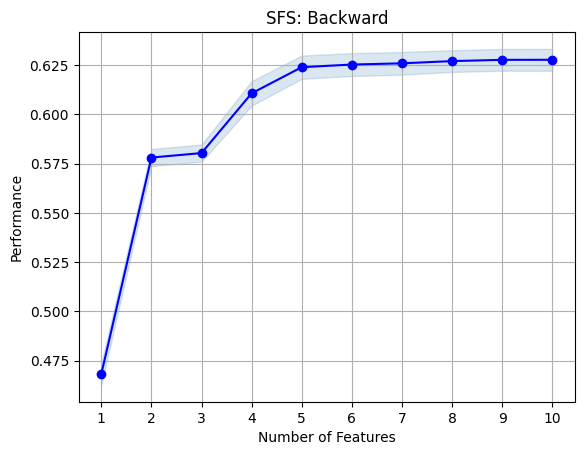

In [49]:
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title("SFS: Backward")
plt.grid()
plt.show()

In [50]:
sfs = SFS(reg,
         k_features='best',
         forward=True,
         floating=False,
         scoring='r2',
         cv=30)

sfs = sfs.fit(X_train,y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T

feature_idx  \
1                             (5,)   
2                           (5, 6)   
3                        (0, 5, 6)   
4                     (0, 2, 5, 6)   
5                  (0, 2, 3, 5, 6)   
6               (0, 2, 3, 4, 5, 6)   
7            (0, 2, 3, 4, 5, 6, 9)   
8         (0, 1, 2, 3, 4, 5, 6, 9)   
9      (0, 1, 2, 3, 4, 5, 6, 7, 9)   
10  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   

                                            cv_scores avg_score  \
1   [0.49457789630187543, 0.4473699911519411, 0.45...    0.4683   
2   [0.6141227275247707, 0.5529151266747793, 0.568...  0.578022   
3   [0.6262319544112371, 0.5695257988465582, 0.586...  0.588077   
4   [0.6295824234210714, 0.5815964560197473, 0.590...  0.596908   
5   [0.6574793636093057, 0.6110481315770739, 0.615...   0.62079   
6   [0.6607588020435091, 0.6149041791249226, 0.627...  0.624487   
7   [0.6604096721275977, 0.6143244214980348, 0.630...  0.625785   
8   [0.6632173367136558, 0.6157159339180818, 0.631...  0.626918   
9   [0.6631442731639794, 0.6156957711031188, 0.631...  0.627556   
10  [0.6632142003682588, 0.614880850375126, 0.6309...  0.627571   

                                        feature_names  ci_bound   std_dev  \
1                                    (median_income,)  0.011306  0.029812   
2                          (median_income, OP_INLAND)  0.008881  0.023419   
3      (housing_median_age, median_income, OP_INLAND)  0.008855  0.023348   
4   (housing_median_age, total_bedrooms, median_in...  0.008946   0.02359   
5   (housing_median_age, total_bedrooms, populatio...  0.010553  0.027826   
6   (housing_median_age, total_bedrooms, populatio...  0.011951  0.031512   
7   (housing_median_age, total_bedrooms, populatio...   0.01176  0.031009   
8   (housing_median_age, total_rooms, total_bedroo...  0.011238  0.029634   
9   (housing_median_age, total_rooms, total_bedroo...    0.0113  0.029795   
10  (housing_median_age, total_rooms, total_bedroo...  0.011266  0.029706   

     std_err  
1   0.005536  
2   0.004349  
3   0.004336  
4    0.00438  
5   0.005167  
6   0.005852  
7   0.005758  
8   0.005503  
9   0.005533  
10  0.005516

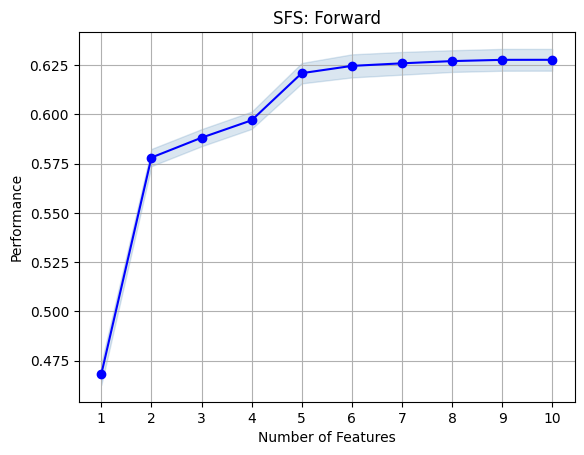

In [51]:
plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title("SFS: Forward")
plt.grid()
plt.show()

In [188]:
model_results["Model"].append("LinearRegression")
model_results["Score"].append(reg.score(X_test,y_test))
model_results["MSE"].append(mean_squared_error(y_true=y_test,y_pred=y_pred_test))

In [10]:
# Set up 5-fold cross validation  
k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    reg = LinearRegression().fit(X_train,y_train)
    # Make predictions with training and test set
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(reg.score(X_train,y_train))
    train_rmse.append(mean_squared_error(y_true=y_train,y_pred=pred_train))
    test_scores.append(reg.score(X_test,y_test))
    test_rmse.append(mean_squared_error(y_true=y_test,y_pred=pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_rmse':train_rmse,'test_scores':test_scores,'test_rmse':test_rmse}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

train_scores    train_rmse  test_scores     test_rmse
0      0.648235  4.677454e+09     0.630773  4.942463e+09
1      0.643100  4.777770e+09     0.654439  4.500378e+09
2      0.644746  4.759304e+09     0.648114  4.570938e+09
3      0.645801  4.691280e+09     0.643645  4.842636e+09
4      0.646443  4.684913e+09     0.641297  4.868204e+09

In [33]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude") # exclude negative values
list_pred_col.remove("latitude") # exclude latitude with longitude
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

# Feature selection
# Select top k features with chi2
k=5
ft = SelectKBest(chi2, k=k).fit(X_train,y_train)
df_chi2 = pd.DataFrame({"Score":ft.scores_,"ColName":X_train.columns})
df_chi2.sort_values("Score",ascending=False).head(k)

Score             ColName
1  7.980884e+06         total_rooms
3  3.405695e+06          population
2  1.195506e+06      total_bedrooms
4  1.110617e+06          households
0  2.007215e+04  housing_median_age

In [34]:
# Transform X
X_train_2 = ft.transform(X_train)
X_test_2 = ft.transform(X_test)

# Define model
reg = LinearRegression()

# Fit model and predict y_pred
reg.fit(X_train_2,y_train)
y_pred_train = reg.predict(X_train_2)
y_pred_test = reg.predict(X_test_2)

# Print scores and MSE
print("Linear regression score (train):",reg.score(X_train_2,y_train))
print("Linear regression score (test):",reg.score(X_test_2,y_test))
print("Linear regression MSE (train):",mean_squared_error(y_true=y_train,y_pred=y_pred_train))
print("Linear regression MSE (test):",mean_squared_error(y_true=y_test,y_pred=y_pred_test))

Linear regression score (train): 0.1541991771293988
Linear regression score (test): 0.15191844997300175
Linear regression MSE (train): 11220737247.409819
Linear regression MSE (test): 11377016788.9509


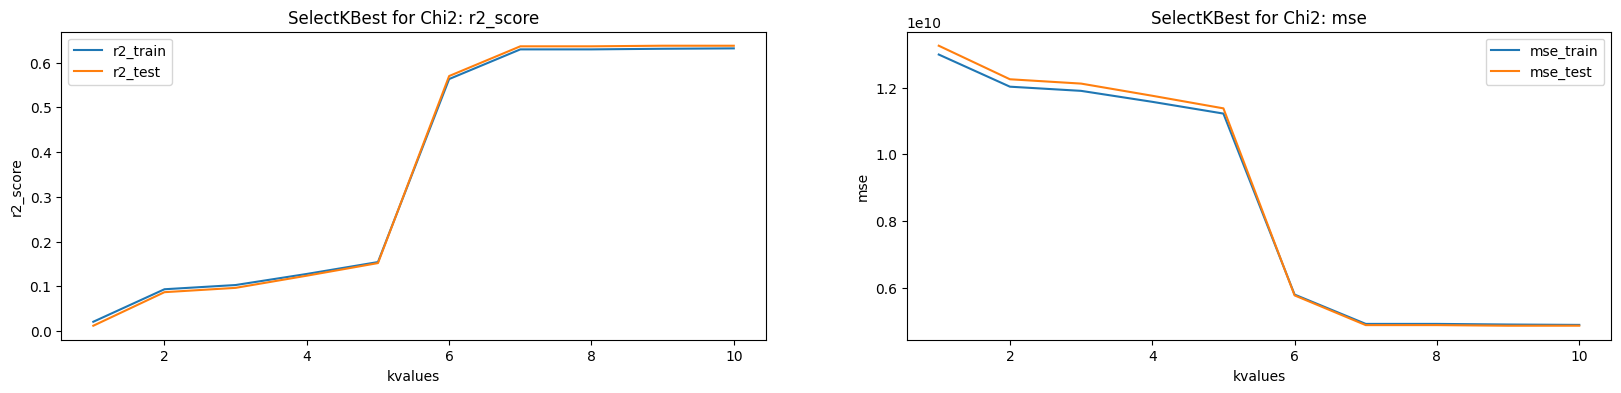

Max r2_train: 0.6317142411253328
Max r2_test: 0.6376316306802008


In [45]:
r2_train = []
r2_test = []
mse_train = []
mse_test = []
kvalues = []

for i in range(1,len(X_train.columns)+1):
    # Feature selection
    # Select top k features with chi2
    k=i
    kvalues.append(k)
    ft = SelectKBest(chi2, k=k).fit(X_train,y_train)

    # Transform X
    X_train_2 = ft.transform(X_train)
    X_test_2 = ft.transform(X_test)

    # Define model
    reg = LinearRegression()

    # Fit model and predict y_pred
    reg.fit(X_train_2,y_train)
    y_pred_train = reg.predict(X_train_2)
    y_pred_test = reg.predict(X_test_2)

    r2_train.append(reg.score(X_train_2,y_train))
    r2_test.append(reg.score(X_test_2,y_test))
    mse_train.append(mean_squared_error(y_true=y_train,y_pred=y_pred_train))
    mse_test.append(mean_squared_error(y_true=y_test,y_pred=y_pred_test))

plt.figure(figsize=(20,4))
r,c = 1,2
plt.subplot(r,c,1)
plt.plot(kvalues,r2_train,label="r2_train")
plt.plot(kvalues,r2_test,label="r2_test")
plt.xlabel("kvalues")
plt.ylabel("r2_score")
plt.title("SelectKBest for Chi2: r2_score")
plt.legend()
plt.subplot(r,c,2)
plt.plot(kvalues,mse_train,label="mse_train")
plt.plot(kvalues,mse_test,label="mse_test")
plt.xlabel("kvalues")
plt.ylabel("mse")
plt.title("SelectKBest for Chi2: mse")
plt.legend()
plt.show()

print("Max r2_train:",np.max(r2_train))
print("Max r2_test:",np.max(r2_test))

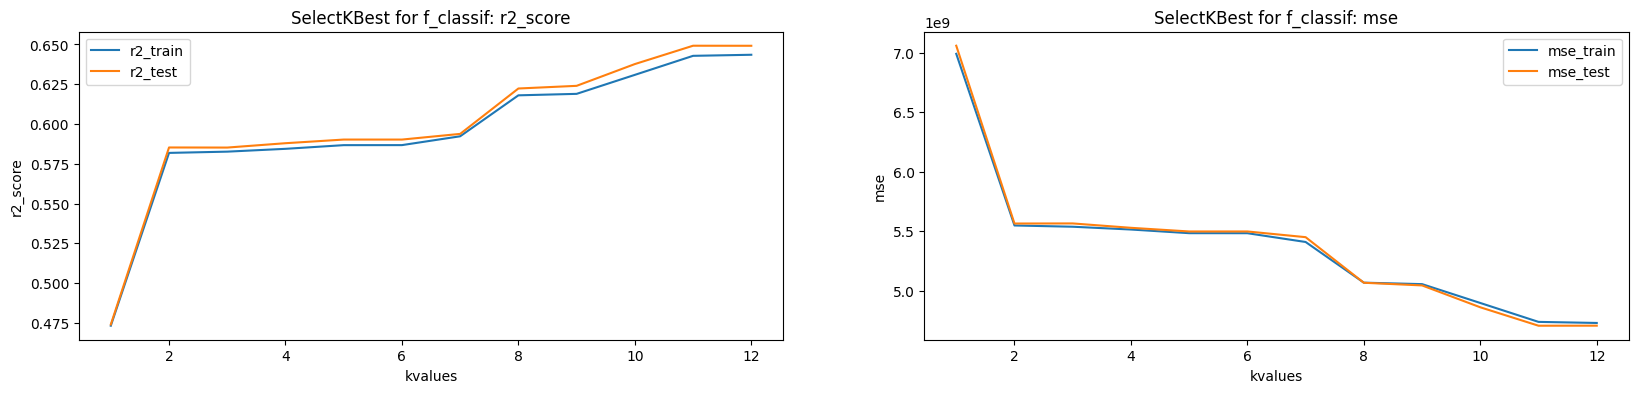

Max r2_train: 0.6434898504197243
Max r2_test: 0.649171674535839


In [66]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
# list_pred_col.remove("longitude") # exclude negative values
# list_pred_col.remove("latitude") # exclude latitude with longitude
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)
r2_train = []
r2_test = []
mse_train = []
mse_test = []
kvalues = []

for i in range(1,len(X_train.columns)+1):
    # Feature selection
    # Select top k features with f_classif
    k=i
    kvalues.append(k)
    ft = SelectKBest(f_classif, k=k).fit(X_train,y_train)

    # Transform X
    X_train_2 = ft.transform(X_train)
    X_test_2 = ft.transform(X_test)

    # Define model
    reg = LinearRegression()

    # Fit model and predict y_pred
    reg.fit(X_train_2,y_train)
    y_pred_train = reg.predict(X_train_2)
    y_pred_test = reg.predict(X_test_2)

    r2_train.append(reg.score(X_train_2,y_train))
    r2_test.append(reg.score(X_test_2,y_test))
    mse_train.append(mean_squared_error(y_true=y_train,y_pred=y_pred_train))
    mse_test.append(mean_squared_error(y_true=y_test,y_pred=y_pred_test))

plt.figure(figsize=(20,4))
r,c = 1,2
plt.subplot(r,c,1)
plt.plot(kvalues,r2_train,label="r2_train")
plt.plot(kvalues,r2_test,label="r2_test")
plt.xlabel("kvalues")
plt.ylabel("r2_score")
plt.title("SelectKBest for f_classif: r2_score")
plt.legend()
plt.subplot(r,c,2)
plt.plot(kvalues,mse_train,label="mse_train")
plt.plot(kvalues,mse_test,label="mse_test")
plt.xlabel("kvalues")
plt.ylabel("mse")
plt.title("SelectKBest for f_classif: mse")
plt.legend()
plt.show()

print("Max r2_train:",np.max(r2_train))
print("Max r2_test:",np.max(r2_test))

#### Ridge Regression: df_housing_dummies

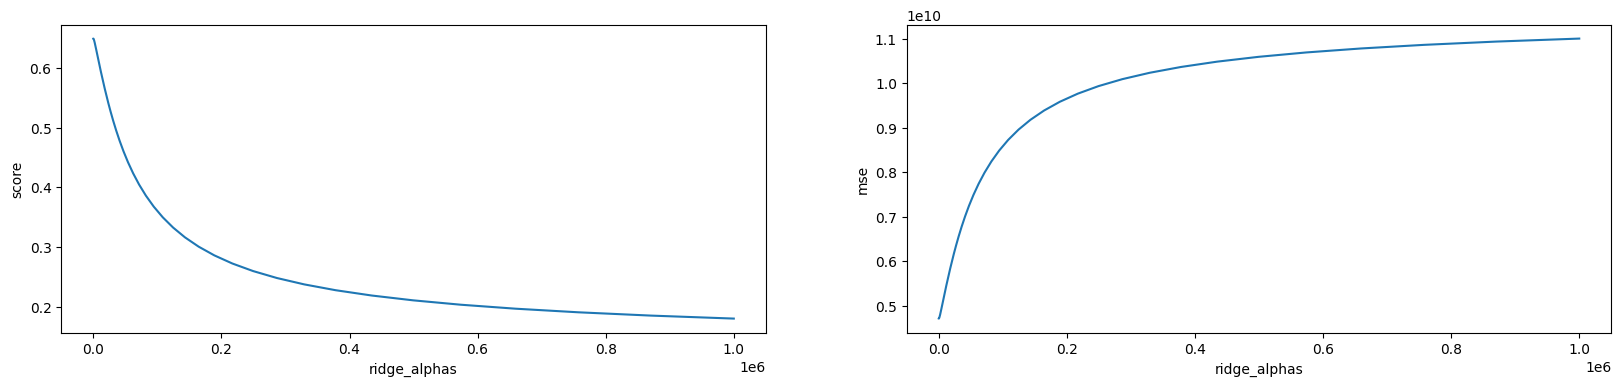

Max ridge score: 0.6491749894322958
Min ridge mse: 4706318673.110606


In [75]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
# list_pred_col.remove("longitude")
# list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

score = []
mse = []

# Get range of alpha values
ridge_alphas = np.logspace(-6, 6, 200)

# Define ridge model
ridge_model = Ridge()

# For each alpha value, get scores and mse
for a in ridge_alphas:
    ridge_model.set_params(alpha = a)
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    score.append(ridge_model.score(X_test,y_test))
    mse.append(mean_squared_error(y_pred=y_pred_ridge,y_true=y_test))

plt.figure(figsize=(20,4))
r,c=1,2
plt.subplot(r,c,1)
plt.plot(ridge_alphas,score)
plt.xlabel("ridge_alphas")
plt.ylabel("score")
plt.subplot(r,c,2)
plt.plot(ridge_alphas,mse)
plt.xlabel("ridge_alphas")
plt.ylabel("mse")
plt.show()

print("Max ridge score:",np.max(score))
print("Min ridge mse:",np.min(mse))

#### RidgeCV Regression: df_housing_dummies

In [18]:
# Get range of alpha values
ridge_alphas = np.logspace(-6, 6, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)
y_pred_ridge = optimal_ridge.predict(X_test)
print("Optimal ridge score:",optimal_ridge.score(X_test,y_test))
print("Optimal ridge mse:",mean_squared_error(y_pred=y_pred_ridge,y_true=y_test))

Optimal ridge score: 0.6375890682131082
Optimal ridge mse: 4861743844.454048


In [19]:
pickle.dump(optimal_ridge, open('ridgeCV.pkl', 'wb'))

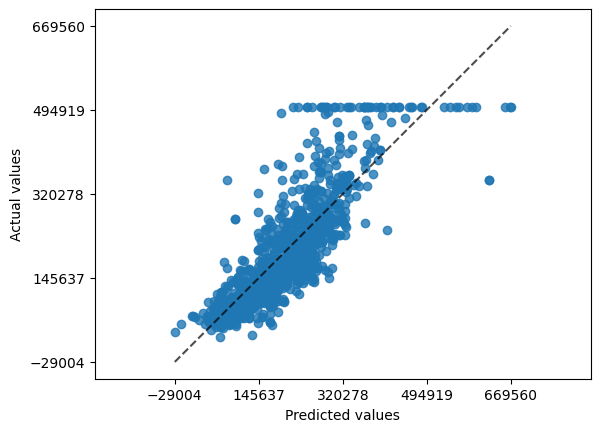

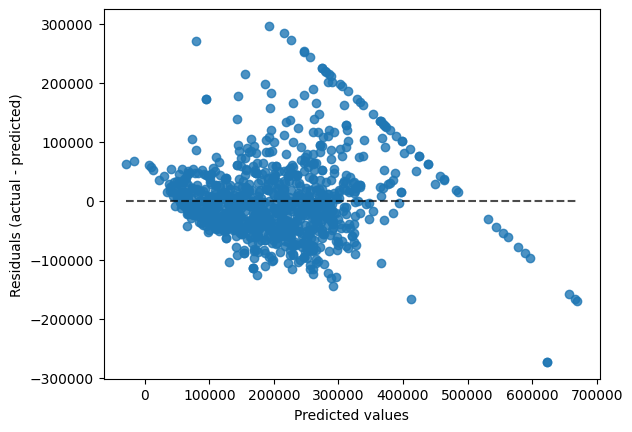

In [156]:
display = PredictionErrorDisplay.from_predictions(y_pred=y_pred_ridge,y_true=y_test,kind="actual_vs_predicted")
display.plot()
plt.show()

In [190]:
model_results["Model"].append("RidgeCV")
model_results["Score"].append(optimal_ridge.score(X_test,y_test))
model_results["MSE"].append(mean_squared_error(y_pred=y_pred_ridge,y_true=y_test))

In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(optimal_ridge,
         k_features='best',
         forward=False,
         floating=False,
         scoring='r2',
         cv=30)

sfs = sfs.fit(X_train,y_train)

pd.DataFrame.from_dict(sfs.get_metric_dict(confidence_interval=0.95)).T


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

AttributeError: SequentialFeatureSelector has not been fitted, yet.

#### Lasso Regression: df_housing_dummies

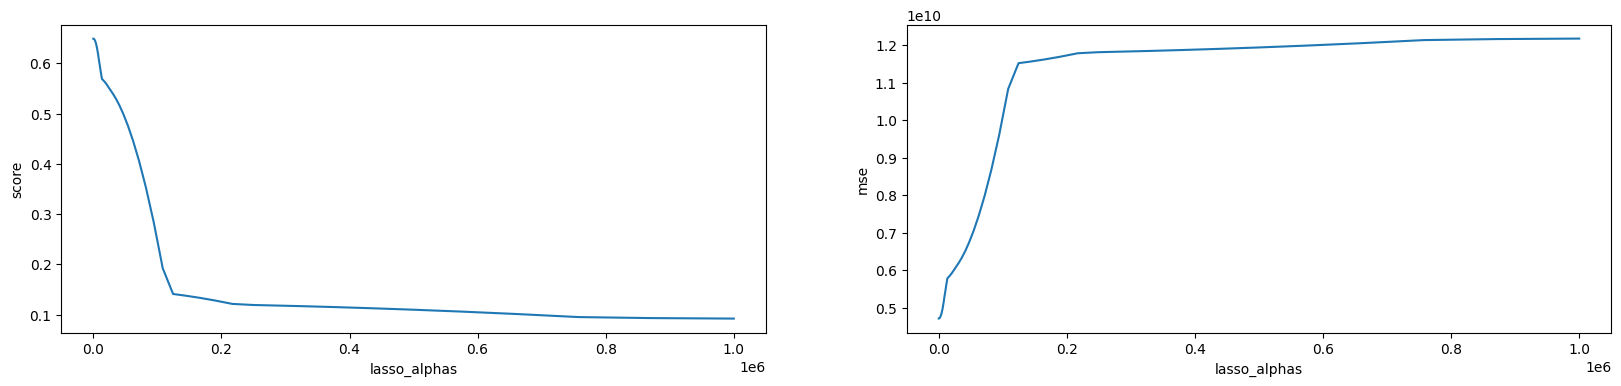

Max lasso score: 0.649206726313369
Min lasso mse: 4705892922.746402


In [85]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
# list_pred_col.remove("longitude")
# list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

score = []
mse = []

# Get range of alpha values
lasso_alphas = np.logspace(-6, 6, 200)

# Define ridge model
lasso_model = Lasso()

# For each alpha value, get scores and mse
for a in lasso_alphas:
    lasso_model.set_params(alpha = a)
    lasso_model.fit(X_train, y_train)
    y_pred_ridge = lasso_model.predict(X_test)
    score.append(lasso_model.score(X_test,y_test))
    mse.append(mean_squared_error(y_pred=y_pred_ridge,y_true=y_test))

plt.figure(figsize=(20,4))
r,c=1,2
plt.subplot(r,c,1)
plt.plot(lasso_alphas,score)
plt.xlabel("lasso_alphas")
plt.ylabel("score")
plt.subplot(r,c,2)
plt.plot(lasso_alphas,mse)
plt.xlabel("lasso_alphas")
plt.ylabel("mse")
plt.show()

print("Max lasso score:",np.max(score))
print("Min lasso mse:",np.min(mse))

#### LassoCV Regression: df_housing_dummies

In [20]:
optimal_lasso = LassoCV(alphas=ridge_alphas, cv=10)
optimal_lasso.fit(X_train, y_train)
y_pred_lasso = optimal_lasso.predict(X_test)
print("Optimal ridge score:",optimal_lasso.score(X_test,y_test))
print("Optimal ridge mse:",mean_squared_error(y_pred=y_pred_lasso,y_true=y_test))

Optimal ridge score: 0.6375890682045731
Optimal ridge mse: 4861743844.568547


In [21]:
pickle.dump(optimal_lasso, open('lassoCV.pkl', 'wb'))

In [192]:
model_results["Model"].append("LassoCV")
model_results["Score"].append(optimal_lasso.score(X_test,y_test))
model_results["MSE"].append(mean_squared_error(y_pred=y_pred_ridge,y_true=y_test))

## Deliver
1. Visualization
2. Summarise: Which model is optimal?

In [193]:
model_results

{'Model': ['LinearRegression', 'RidgeCV', 'LassoCV'],
 'Score': [0.6375890682042074, 0.6375890682131082, 0.6375890682045731],
 'MSE': [4861743844.573455, 4861743844.454048, 4861743844.454048]}

In [194]:
df_results = pd.DataFrame(model_results)
df_results

Model     Score           MSE
0  LinearRegression  0.637589  4.861744e+09
1           RidgeCV  0.637589  4.861744e+09
2           LassoCV  0.637589  4.861744e+09

NameError: name 'y_pred_test' is not defined

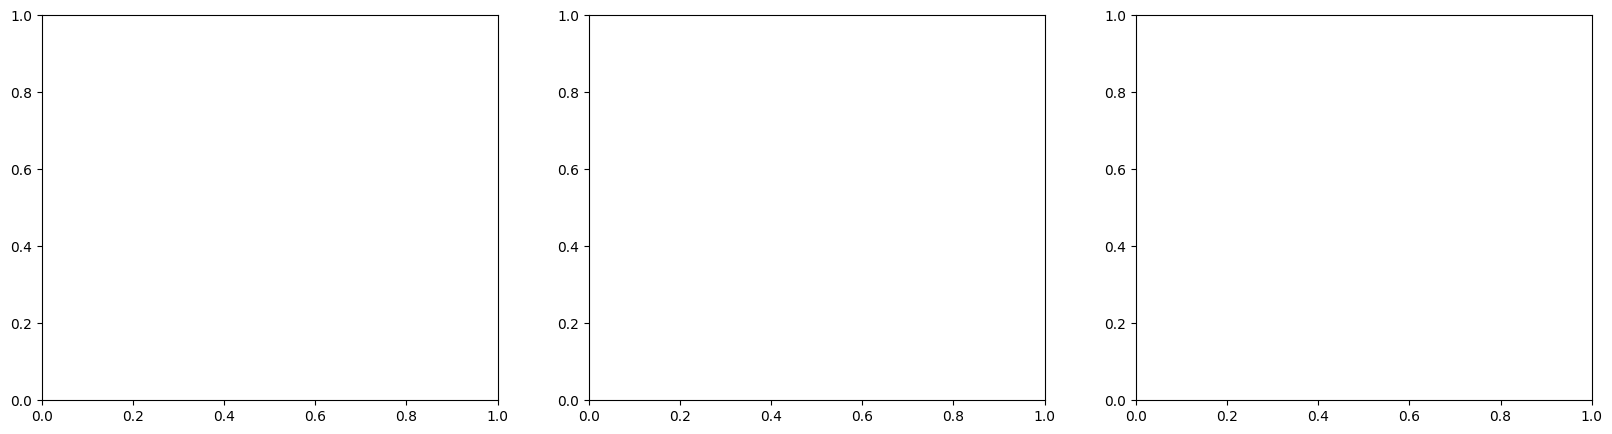

In [2]:
# Model evaluation
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = np.ravel(axs)
list_y_pred = [y_pred_test,y_pred_ridge,y_pred_lasso]
for ax,y_pred in zip(axs,list_y_pred):
    display = PredictionErrorDisplay.from_predictions(y_pred=y_pred,y_true=y_test,kind="actual_vs_predicted",scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},ax=ax)
plt.tight_layout()
plt.show()

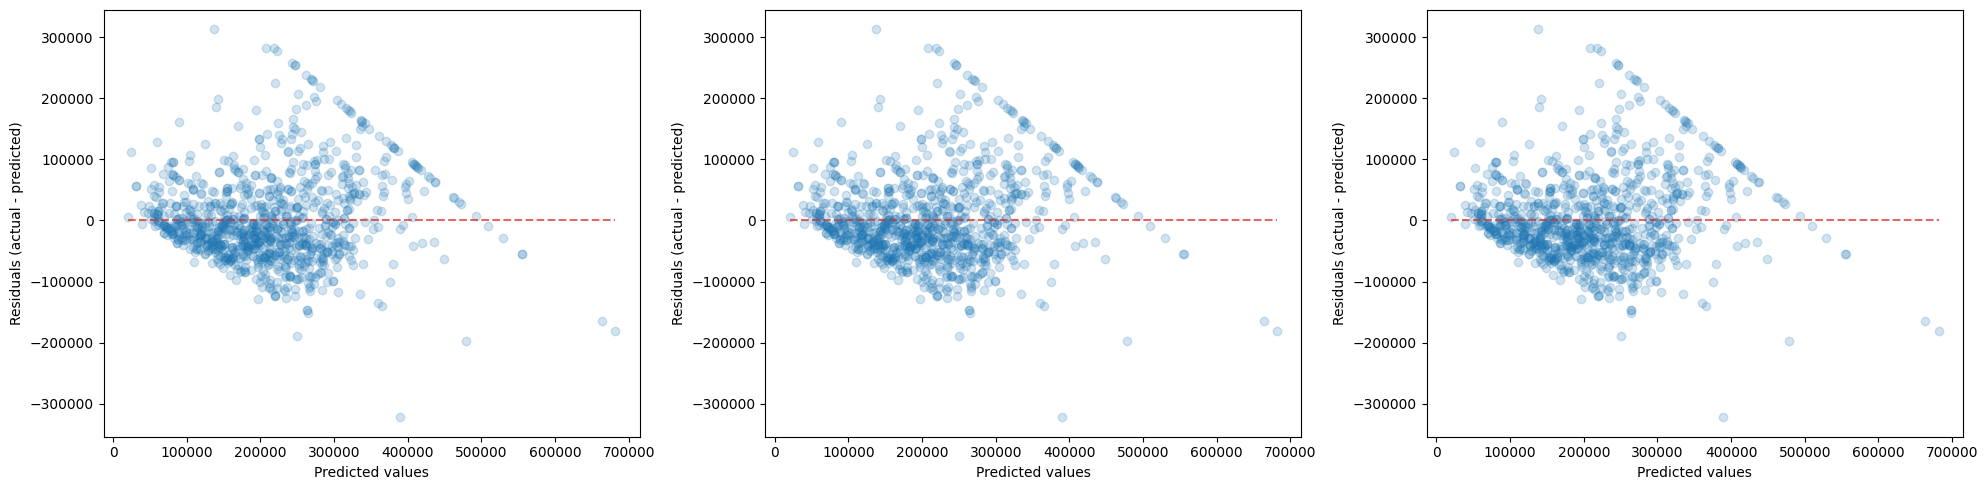

In [201]:
fig, axs = plt.subplots(1,3, figsize=(20,5))
axs = np.ravel(axs)
list_y_pred = [y_pred_test,y_pred_ridge,y_pred_lasso]
for ax,y_pred in zip(axs,list_y_pred):
    display = PredictionErrorDisplay.from_predictions(y_pred=y_pred,y_true=y_test,kind="residual_vs_predicted",scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
            line_kwargs={"color": "tab:red"},ax=ax,random_state=23)
plt.tight_layout()
plt.show()

## TEST

In [28]:
# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude")
list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define model
reg = LinearRegression()

# Fit model and predict y_pred
reg.fit(X,y)
y_pred = reg.predict(X)

# Print scores and MSE
print("Linear regression score (train):",reg.score(X,y))
print("Linear regression MSE (train):",mean_squared_error(y_true=y,y_pred=y_pred))

# Set up 5-fold cross validation  
k_fold = KFold(5, shuffle=True)
train_scores = []
train_rmse = []
test_scores = []
test_rmse = []

for k, (train, test) in enumerate(k_fold.split(X)):
    # Get training and test sets for X and y
    X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
    # Fit model with training set
    reg = LinearRegression().fit(X_train,y_train)
    # Make predictions with training and test set
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)
    # Score R2 and RMSE on training and test sets and store in list
    train_scores.append(reg.score(X_train,y_train))
    train_rmse.append(mean_squared_error(y_true=y_train,y_pred=pred_train))
    test_scores.append(reg.score(X_test,y_test))
    test_rmse.append(mean_squared_error(y_true=y_test,y_pred=pred_test))
# Create a metrics_df dataframe to display r2 and rmse scores
dict_metrics = {'train_scores':train_scores,'train_rmse':train_rmse,'test_scores':test_scores,'test_rmse':test_rmse}
metrics_df = pd.DataFrame(dict_metrics)
metrics_df

Linear regression score (train): 0.6337700860025437
Linear regression MSE (train): 4876535518.822475


train_scores    train_rmse  test_scores     test_rmse
0      0.632342  4.932857e+09     0.639150  4.658191e+09
1      0.636777  4.850897e+09     0.618852  5.013954e+09
2      0.636606  4.830952e+09     0.621770  5.068678e+09
3      0.631663  4.898742e+09     0.641664  4.792960e+09
4      0.632305  4.857777e+09     0.639086  4.955554e+09

{'fit_time': array([0.00760436, 0.00698423, 0.00533676, 0.00631046, 0.004987  ]), 'score_time': array([0.00299239, 0.00199461, 0.00199652, 0.00199437, 0.00254726]), 'test_r2': array([0.47822698, 0.49455227, 0.60305859, 0.4827604 , 0.6712981 ]), 'test_neg_mean_squared_error': array([-5.60526278e+09, -5.91658477e+09, -5.71012373e+09, -6.06817424e+09,
       -4.78970780e+09])}
[461676.42643697 474889.44303382 431850.91592448 ...  64830.77375433
  72718.81350636  91295.93850173]
{'R2': '0.55 +- 0.08', 'MSE': '5617970663.86 +- 444190655.50'}
{'fit_time': array([0.66945791, 0.67598367, 0.68247795, 0.67645979, 0.67616105]), 'score_time': array([0.0039947 , 0.00399041, 0.00215602, 0.00217724, 0.00199389]), 'test_r2': array([0.47830048, 0.49456137, 0.60300949, 0.48278436, 0.67129598]), 'test_neg_mean_squared_error': array([-5.60447321e+09, -5.91647820e+09, -5.71083002e+09, -6.06789324e+09,
       -4.78973871e+09])}
[461654.59132112 474876.84685849 431835.4391283  ...  64837.49235186
  72729.808

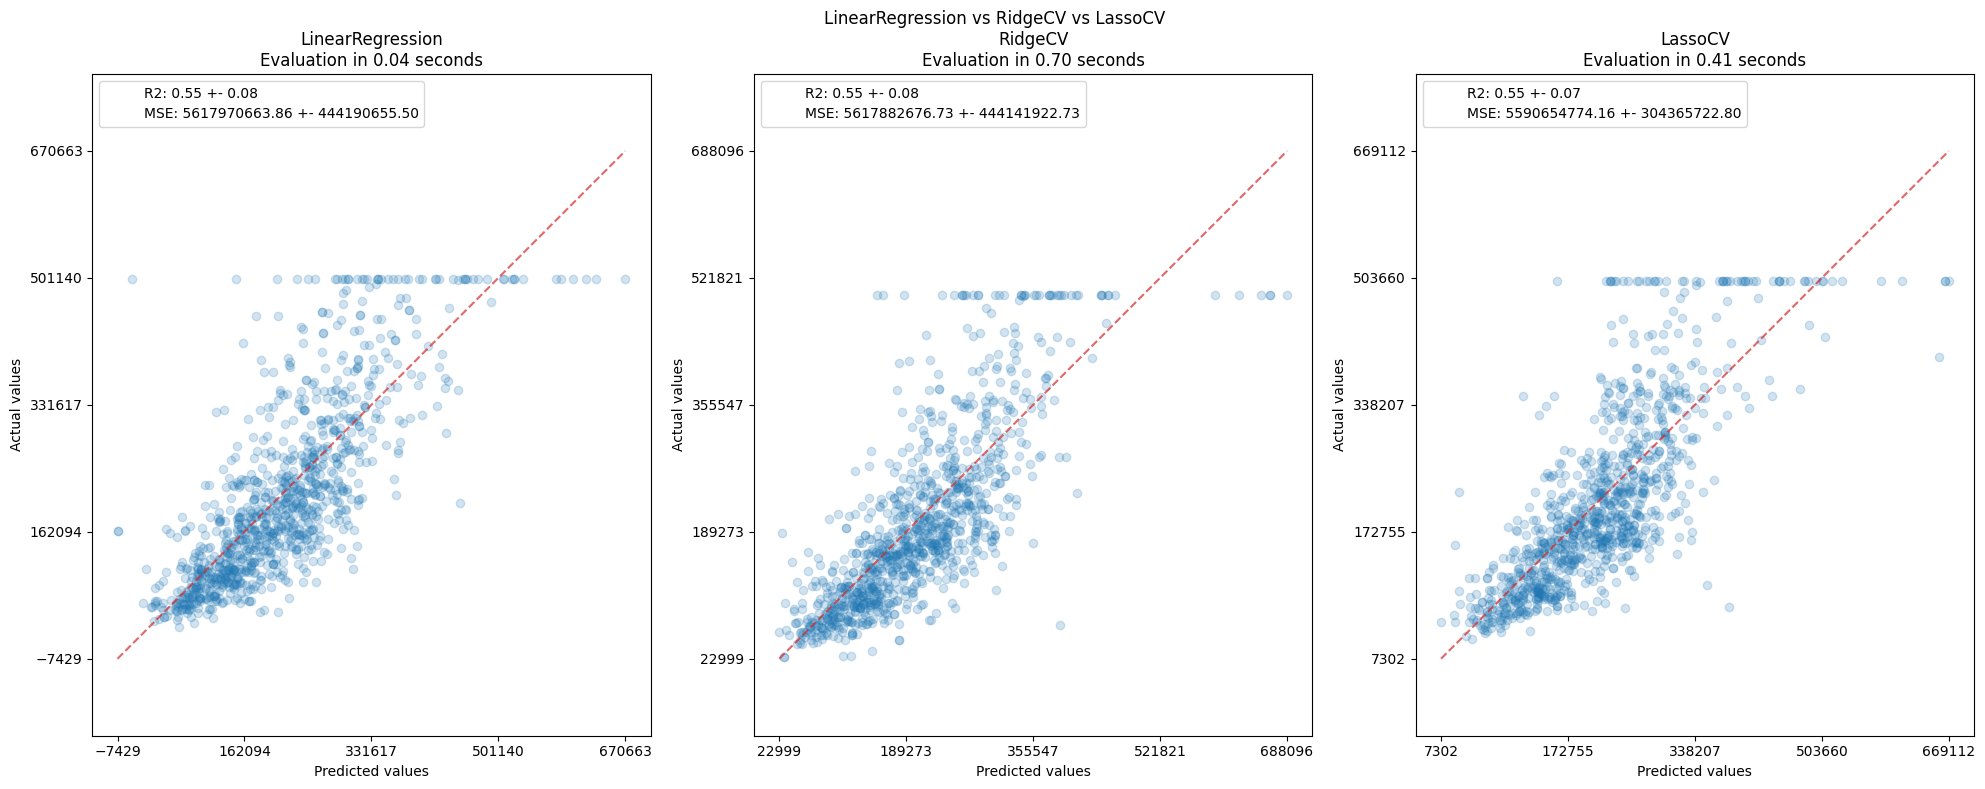

In [23]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude")
list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = np.ravel(axs)

estimators = [
    ("LinearRegression", LinearRegression()),
    ("RidgeCV", RidgeCV(alphas=ridge_alphas, cv=None)),
    ("LassoCV", LassoCV(alphas=ridge_alphas, cv=None)),
]

for ax, (name, est) in zip(axs, estimators):
    
    scorers = {"R2": "r2", "MSE": "neg_mean_squared_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time
    print(scores)
    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    print(y_pred)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }
    print(scores)
    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("LinearRegression vs RidgeCV vs LassoCV")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [17]:
X_test.shape

(6812, 10)

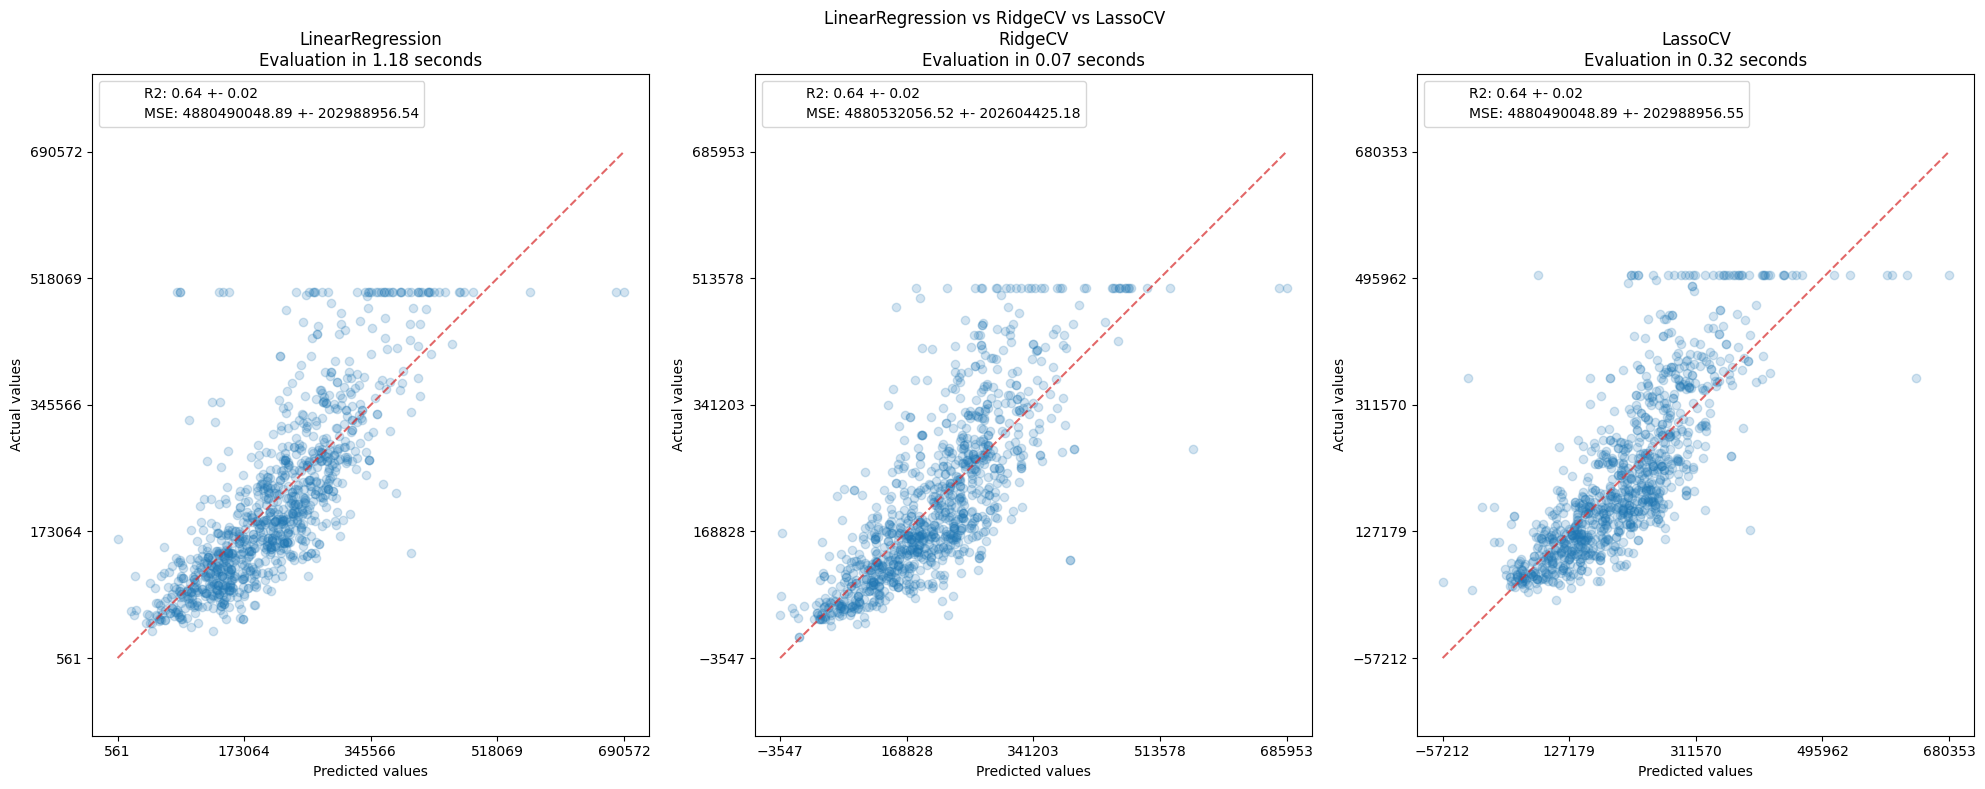

In [21]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude")
list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=23)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = np.ravel(axs)

estimators = [
    ("LinearRegression", LinearRegression()),
    ("RidgeCV", RidgeCV(alphas=ridge_alphas, cv=None)),
    ("LassoCV", LassoCV(alphas=ridge_alphas, cv=None)),
]

for ax, (name, est) in zip(axs, estimators):
    
    scorers = {"R2": "r2", "MSE": "neg_mean_squared_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X_test, y_test, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_test, y_test, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
        # random_state=23
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("LinearRegression vs RidgeCV vs LassoCV")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

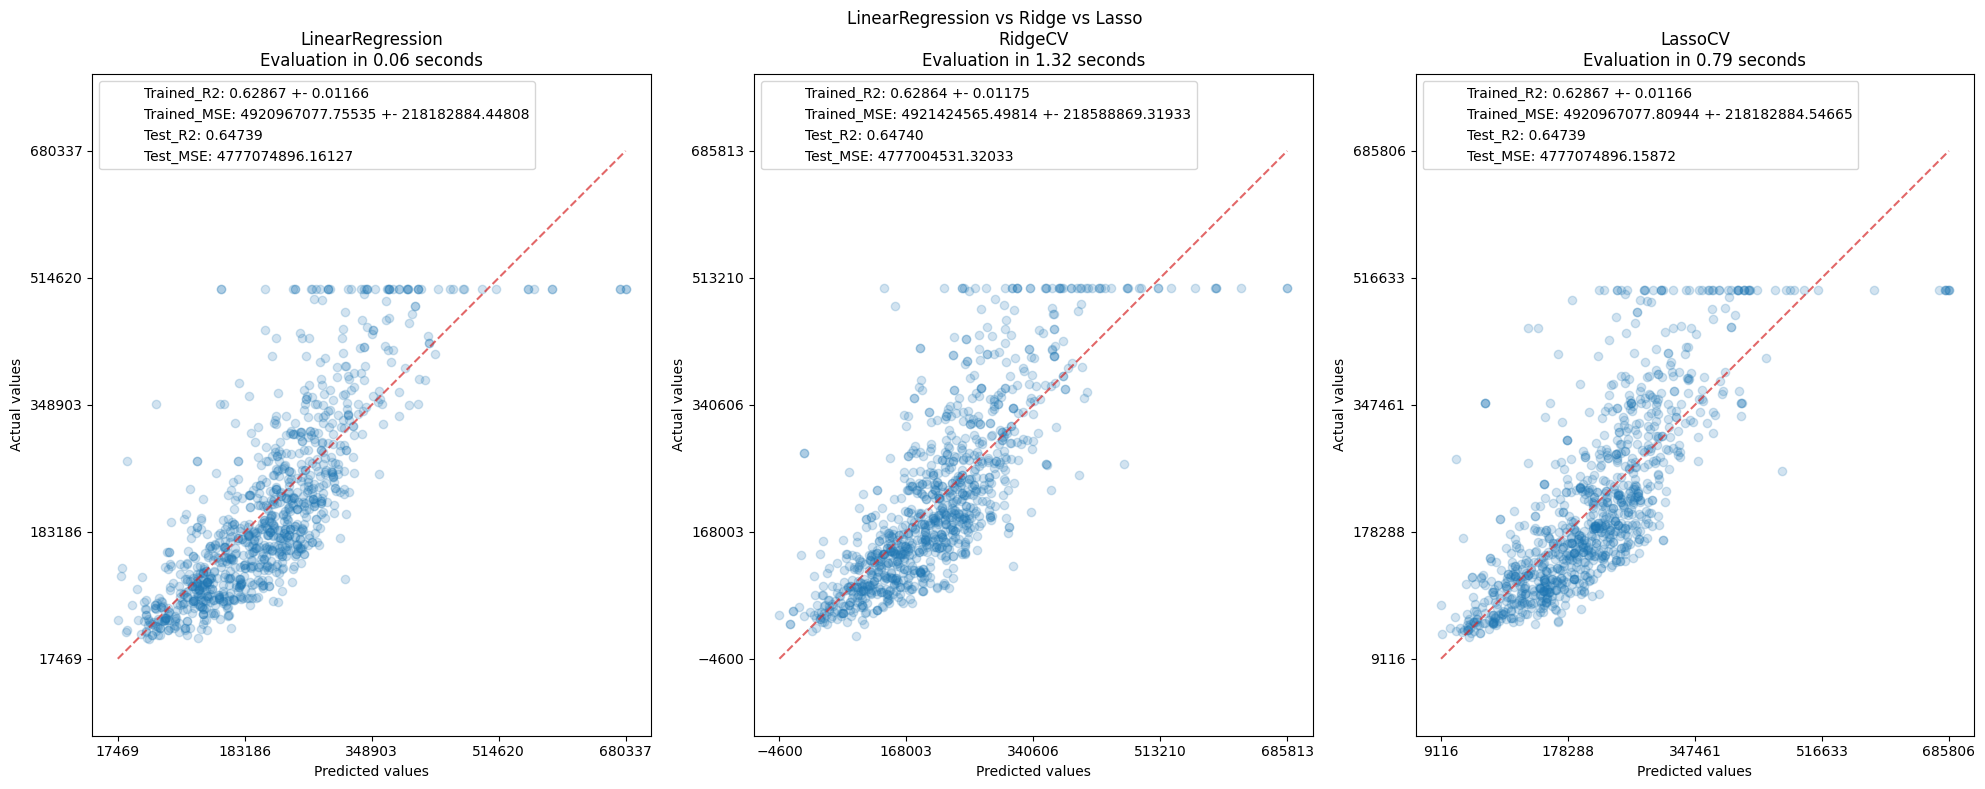

In [45]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

# Define predictor and target variables
list_pred_col = df_housing_dummies.columns.tolist()
list_pred_col.remove("median_house_value") # excluding target variable
list_pred_col.remove("longitude")
list_pred_col.remove("latitude")
X = df_housing_dummies[list_pred_col]
y = df_housing_dummies["median_house_value"]

# Define train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=23)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = np.ravel(axs)

estimators = [
    ("LinearRegression", LinearRegression()),
    ("RidgeCV", RidgeCV(alphas=ridge_alphas, cv=None)),
    ("LassoCV", LassoCV(alphas=ridge_alphas, cv=None)),
]

for ax, (name, est) in zip(axs, estimators):
    scorers = {"R2": "r2", "MSE": "neg_mean_squared_error"}
    
    start_time = time.time()
    scores = cross_validate(
        est, X_train, y_train, scoring=list(scorers.values()), n_jobs=-1, verbose=0, cv=10
    )
    elapsed_time = time.time() - start_time
    
    ft = est.fit(X_train, y_train)
    y_pred_test = ft.predict(X_test)
    test_score = ft.score(X_test,y_test)
    test_mse = mean_squared_error(y_true=y_test,y_pred=y_pred_test)
    # y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0,cv=10)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.5f} +- "
            f"{np.std(scores[f'test_{value}']):.5f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_estimator(
        estimator=ft,
        X=X_test,
        y=y_test,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"Trained_{name}: {score}")
    ax.plot([], [], " ", label=f"Test_R2: {test_score:.5f}")
    ax.plot([], [], " ", label=f"Test_MSE: {test_mse:.5f}")
    ax.legend(loc="upper left")

plt.suptitle("LinearRegression vs Ridge vs Lasso")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()